In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

%matplotlib inline

<h1>Analysis of categorical data - Chi-Square tests</h1>

The Chi-Square test uses the following formula to give statistical output:

$$\chi_v^2=\sum_{i=1}^{n}\frac{(O_i-E_i)^2}{E_i}$$

Where:
- _v_ denotes the degree of freedom
- _O_ implies the sample observed values
- _E_ stands for the population expected values
- _n_ indicates the variable category counts

# Contigency table

A contingency table displays sample values in relation to two different variables that may be dependent or contingent on one another.

|Categories|Group 1|Group 2| Row total|
|---       |:---:  |:---:  |:---:     |
|category 1|a.     |c.     |a+c.      |
|category 2|b.     |d.     |b+d.      |
|column total|a+b. |c+d.   |a+b+c+d=n |


Creating contigency tables from raw data:

In [2]:
initial_data = pd.DataFrame({'Gender' : ['M', 'M', 'M', 'F', 'F'] * 10,
                   'isSmoker' : ['Smoker', 'Smoker', 'Non-Smoker', 'Non-Smoker', 'Smoker'] * 10
                  })

contigency_table = pd.crosstab(initial_data['Gender'], initial_data['isSmoker']) # normalize='all' 'index' 'columns' to get percentages
contigency_table

isSmoker,Non-Smoker,Smoker
Gender,,
F,10,10
M,10,20


<Axes: xlabel='isSmoker', ylabel='Gender'>

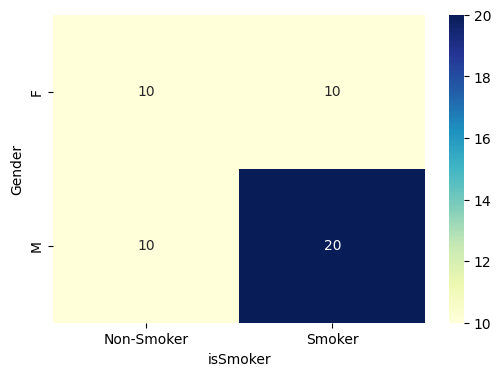

In [3]:
plt.figure(figsize=(6,4))
sns.heatmap(contigency_table, annot=True, cmap="YlGnBu")

#Goodness of fit test
Chi-Square Goodness of fit test validates the observed distribution of categorical variables to the expected distribution. It tells us if the available event values differ from the expected values.


Human "randomness" experiment:

N = 200 people, asked to "mentally shuffle the deck, pick a card, report suit"


H</sub>0</sub> : All four suits are chosen with equal probability. P = (0.25, 0.25, 0.25, 0.25)

H</sub>1</sub> : At least one of the suit-choice probabilities isn't 0.25. P ≠ (0.25, 0.25, 0.25, 0.25)

In [17]:
N = 200
initial_data = {
    'type': ['clubs', 'dimonds', 'hearts', 'spades'],
    'Oi': [35,51,64,50],
}

initial_df = pl.DataFrame(initial_data)
initial_df

type,Oi
str,i64
"""clubs""",35
"""dimonds""",51
"""hearts""",64
"""spades""",50


If H<sub>0</sub> is true what will be the value of expected frequencies (E)?</br> Probability expected to be 0.25 for each suit.

$$E_i = N * P_i = 200 * 0.25 = 50$$

In [18]:
# add expected probability to the table
working_df = initial_df.with_columns(Pe = 1 / pl.col('type').count())
# calculate expected event rates
working_df = working_df.with_columns((N * pl.col('Pe')).alias('Ei'))
# calculate difference of observed and expected event rates
working_df = working_df.with_columns((pl.col('Oi') - pl.col('Ei')).alias('Diff'))
# calculate squared difference
working_df = working_df.with_columns((pl.col('Diff') ** 2).alias('Diff squared'))
# calculate scaled squared difference
working_df = working_df.with_columns((pl.col('Diff squared') / pl.col('Ei')).alias('Diff squared scaled'))
working_df

type,Oi,Pe,Ei,Diff,Diff squared,Diff squared scaled
str,i64,f64,f64,f64,f64,f64
"""clubs""",35,0.25,50.0,-15.0,225.0,4.5
"""dimonds""",51,0.25,50.0,1.0,1.0,0.02
"""hearts""",64,0.25,50.0,14.0,196.0,3.92
"""spades""",50,0.25,50.0,0.0,0.0,0.0


$\chi$<sup>2</sup> is a sum of scaled squares of differences between expected and observed event rates.

$$\chi^2 = \sum_{i}^{rows}\sum_{j}^{cols}\frac{(E_{ij}-O_{ij})^2}{E_{ij}}$$

$$degreesOfFreedom = rows - 1$$


In [19]:
# calculate chi-square statistic by summing up scaled squared difference column
chi_square_statistic = working_df.select((pl.col('Diff squared scaled'))).sum().item()
degrees_of_freedom = initial_df.shape[0] - 1
print(f"Chi-Square statistic: {chi_square_statistic}")
print(f"Degrees of freedom: {degrees_of_freedom}")

Chi-Square statistic: 8.44
Degrees of freedom: 3


Critical value: 7.81 
Chi-Square statistic: 8.44 
P-value: 0.038



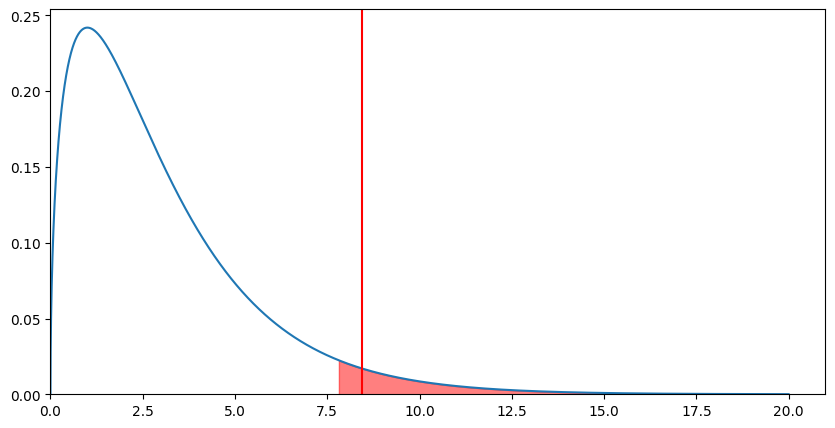

In [21]:
x = np.arange(0, 20, 0.001)

critical_value = stats.chi2.ppf(1-0.05, df=degrees_of_freedom)
p_value = stats.chi2.sf(chi_square_statistic, df=degrees_of_freedom)
print(f"Critical value: {critical_value:.2f} \nChi-Square statistic: {chi_square_statistic:.2f} \nP-value: {p_value:.3f}", end='\n\n')

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(x, stats.chi2.pdf(x, df=degrees_of_freedom))
ax.axvline(chi_square_statistic, color='red')
ax.set_xlim(0)
ax.set_ylim(0)
ax.fill_between(x, stats.chi2.pdf(x, df=degrees_of_freedom), where=x>critical_value, color='red', alpha=0.5)
plt.show()

Value 8.44 > Critical value 7.81 OR p(GOF) = 0.038 < $\alpha$

Thus we can reject the null hypothesis.


## Automatic calculation

In [9]:
chi_square_statistic, p_value = stats.chisquare(initial_df.select(pl.col('Oi')))
print(f"Chi-Square statistic: {chi_square_statistic[0]}")
print(f"P-value: {p_value[0]:.3f}")

Chi-Square statistic: 8.44
P-value: 0.038


#Test of independence (or association)

Determines if events are independent.

Here we have contigency table as initial data.

In [10]:
initial_df = pl.DataFrame({
    'genotype': ['AA', 'AG', 'GG'],
    'O_desease': [250, 45, 5,],
    'O_control': [348, 56, 2],
})

## Manual step-by-step calculation

In [11]:
# calculating total by row
working_df = initial_df.with_columns((pl.col('O_desease') + pl.col('O_control')).alias('total'))
working_df

genotype,O_desease,O_control,total
str,i64,i64,i64
"""AA""",250,348,598
"""AG""",45,56,101
"""GG""",5,2,7


Mutation: rs1287 A>G

H<sub>0</sub> : Mutant allele (G) genotypes are not associated with the Disease.

H<sub>1</sub> : Mutant allele (G) genotypes are associated with the Disease.

<h2>Calculating expected frequency</h2>

If genotypes (A) and disease (B) are independent, then

$$P(A \cap B) = P(A)*P(B)$$

P<sub>disease</sub> = 300/706

P<sub>AA</sub> = 598/706

E<sub>1,1</sub> = P<sub>disease</sub> \* P<sub>AA</sub> \* N

In [12]:
# calculate Expected desease
working_df = working_df.with_columns(((pl.sum('O_desease') / pl.sum('total'))*(pl.col('total')/pl.sum('total'))* pl.sum('total')).alias('E_desease'))
# calculate Expected control
working_df = working_df.with_columns(((pl.sum('O_control') / pl.sum('total'))*(pl.col('total')/pl.sum('total'))* pl.sum('total')).alias('E_control'))
# calculate Squared difference for desease
working_df = working_df.with_columns((((pl.col('O_desease') - pl.col('E_desease'))**2)/pl.col('E_desease')).alias('Desease_diff_squared'))
# calculate Squared difference for control
working_df = working_df.with_columns((((pl.col('O_control') - pl.col('E_control'))**2)/pl.col('E_control')).alias('Control_diff_squared'))
working_df

genotype,O_desease,O_control,total,E_desease,E_control,Desease_diff_squared,Control_diff_squared
str,i64,i64,i64,f64,f64,f64,f64
"""AA""",250,348,598,254.107649,343.892351,0.0664,0.049064
"""AG""",45,56,101,42.917847,58.082153,0.101015,0.074642
"""GG""",5,2,7,2.974504,4.025496,1.379266,1.019162


$\chi$<sup>2</sup> is a sum of scaled squares of differences between expected and observed event rates.

$$\chi^2 = \sum_{i}^{rows}\sum_{j}^{cols}\frac{(E_{ij}-O_{ij})^2}{E_{ij}}$$

$$degreesOfFreedom = (rows - 1) * (cols - 1)$$

In [13]:
chi_square_statistic = working_df.select((pl.sum('Desease_diff_squared') + pl.sum('Control_diff_squared'))).item()
cols = working_df.select((pl.col(pl.Int64))).n_unique() - 1
rows = initial_df.shape[0] - 1
cols = initial_df.shape[1] - 1 - 1 # here we also exclude genotype (index) column
degrees_of_freedom = rows * cols
print(f"Chi-Square statistic: {chi_square_statistic}")
print(f"Degrees of freedom: {degrees_of_freedom}")

Chi-Square statistic: 2.6895498036455154
Degrees of freedom: 2


Critical value: 5.99, 
Chi-Square statistic: 2.69, 
P-value: 0.261



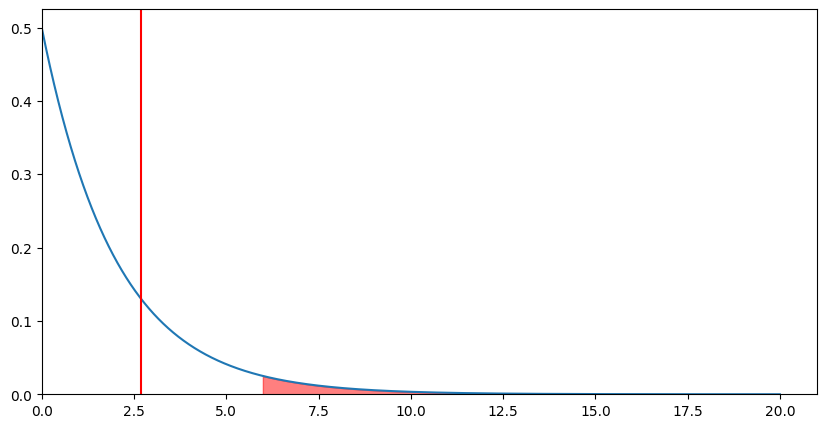

In [14]:
x = np.arange(0, 20, 0.001)

critical_value = stats.chi2.ppf(1-0.05, df=degrees_of_freedom)
p_value = stats.chi2.sf(chi_square_statistic, df=degrees_of_freedom)
print(f"Critical value: {critical_value:.2f} \nChi-Square statistic: {chi_square_statistic:.2f} \nP-value: {p_value:.3f}", end='\n\n')

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(x, stats.chi2.pdf(x, df=degrees_of_freedom))
ax.axvline(chi_square_statistic, color='red')
ax.set_xlim(0)
ax.set_ylim(0)
ax.fill_between(x, stats.chi2.pdf(x, df=degrees_of_freedom), where=x>critical_value, color='red', alpha=0.5)
plt.show()

Value 2.69 < Critical value 5.99 OR p(GOF) = 0.261 > $\alpha$

We fail to reject null hypothesis, thus mutant allele (G) genotypes are not associated with the Disease.

## Automatic calculation

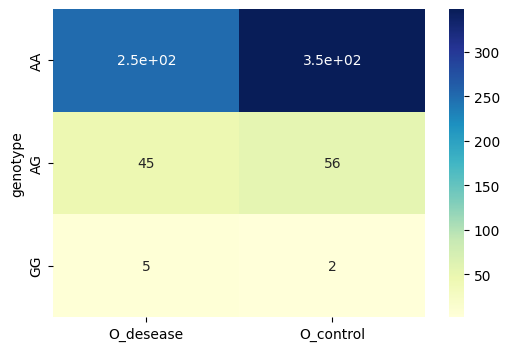


Chi-Square statistic: 2.69
P-value: 0.261
Degrees of freedom: 2
Expected values: 
[[254.10764873 343.89235127]
 [ 42.91784703  58.08215297]
 [  2.97450425   4.02549575]]


In [15]:
contigency_table = initial_df.to_pandas().set_index('genotype')

plt.figure(figsize=(6,4))
sns.heatmap(contigency_table, annot=True, cmap="YlGnBu")
plt.show()

chi_square_statistic, p_value, degrees_of_freedom, expected = stats.chi2_contingency(contigency_table)

print(f"\nChi-Square statistic: {chi_square_statistic:.2f}")
print(f"P-value: {p_value:.3f}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print(f"Expected values: \n{expected}")

Here we get the same data as by manual calculation.

#Test of a single variance / Test for Homogeneity
tests variability

Test for homogeneity, can be used to draw a conclusion about whether two populations have the same distribution.

H<sub>0</sub> : The distributions of the two populations are the same.

H<sub>1</sub> : The distributions of the two populations are not the same.

$\chi$<sup>2</sup> test statistic computed in the same way as the test for independence.

df = number of columns - 1


<h2>The continuity correction / The Yates correction</h2>

- The $\chi$<sup>2</sup> test is based on an approximation that the binomial distribution starts to look like a normal distribution for large N.

- With df = 1 (2x2 contingency tables), this is not always the case and can introduce systemic bias when N is small.



$$\chi^2 = \sum_{i} \frac{(|E_i - O_i| - 0.5)^2}{E_i}$$

<h2>Assumptions of the test(s)</h2>

- Expected frequencies are sufficiently large. Expected frequencies larger than 5.

- Data are independent of one another. If violated consider McNemar test or the Cochran test.


<h2>The Effect size</h2>

$\varphi$ statistic (for 2x2 tables)

range: 0-1,

where 0 - no effect, 1 - strongest effect

$$\varphi = \sqrt{\frac{x^2}{N}}$$


<h2>Cramer’s V statistic (for bigger tables)</h2>

range: 0-1,

where 0 - no effect, 1 - strongest effect

$$V = \sqrt{\frac{x^2}{N(k - 1)}}, k = min(row, column)$$



<h2>Fisher Exact test</h2>

Fishers exact test determines whether a statistically significant association exists between two categorical variables.

When to use Fisher’s exact test (instead of $\chi$<sup>2</sup> test for independence):
- Cell counts are smaller than 20
- A cell has an expected value 5 or less.
- The column or row marginal values are extremely uneven.

<h2>Hypotheses</h2>

H<sub>0</sub>:The two variables are independent.

H<sub>1</sub>: The two variables are not independent.

Fisher test calculates the number of all possible contingency tables with the same row and column totals as the observed table.
Then it calculates the probability for the p-value by finding the proportion of possible tables that are more extreme than the observed table.

<h2>How p is calculated for Fisher Exact test</h2>

|Categories|Group 1|Group 2| Row total|
|---       |:---:  |:---:  |:---:     |
|category 1|a.     |c.     |a+c.      |
|category 2|b.     |d.     |b+d.      |
|column total|a+b. |c+d.   |a+b+c+d=n |

$$p = \frac{(a+b)!(c+d)!(a+c)!(b+d)!}{a!b!c!d!n!}$$

equivalent to probability of hypergeometric distribution with following parameters:
- population size = n
- population "successes" = a+b
- sample size = a + c
- sample "successes" = a


<h2>Fisher exact test applications</h2>

Test whether known biological functions or processes are over-represented (= enriched) in an experimentally-derived gene list, e.g. a list of differentially expressed (DE) genes.

Refer to:
https://isglobal-brge.github.io/Master_Bioinformatics/enrichment-analysis.html